# Automate 'What if?' Scenarios in openLCA
This script opens an IPC server connection with an active openLCA database that contains electricity baseline generation processes and has an impact assessment method (e.g., TRACI 2.1 with appropriate flow mappings).
The script will search for the generation-level processes, update their exchange values based on a given 'what-if' scenario, run the US-consumption level product system through TRACI impact assessment, and save their results to Excel.

Based on 'Generate Product Systems and Results from openLCA Processes' Jupyter notebook created by M. Jamieson and updated to v2 by T.W. Davis.
Last updated by T.W. Davis (2025-01-16).

## Getting things ready

In [1]:
# Import necessary modules
import os
import re

try:
    import olca_ipc as olca
    import olca_schema as o
except ModuleNotFoundError:
    print("Run the install olca-ipc line below")
import pandas as pd
import matplotlib.pyplot as plt

If you received a warning message above, run the following; otherwise skip.

In [ ]:
!pip install olca-ipc

Prepare matlab configuration for Jupyter notebooks.

In [2]:
%matplotlib inline

For this study, I did the following:

1. Download the Electricity Baseline database from the [Federal LCA Commons](https://www.lcacommons.gov/lca-collaboration/Federal_LCA_Commons/US_electricity_baseline/datasets), and import it into a new openLCA database.
2. Activate the database (if not already)
3. Start the IPC Service

In openLCA, activate the database you want to interact with and go to _Tools > Developer tools > IPC Server_. Set the servers port number and click the green play button (don't close or stop while running the code below). Use the same number below.

__Remember to do this on a copy database!__

The default port number is 8080.

In [3]:
my_port_number = 8080
olca_client = olca.Client(my_port_number)

## Searching the database

In the cells below, let's use regex to search for generation processes.

In [4]:
# Remember to oupdate only U.S. fuel categories (keep Canada's 'ALL' category unchanged).
FUEL_CATS = [
    "ALL",
    "BIOMASS",
    "COAL",
    "GAS",
    "GEOTHERMAL",
    "HYDRO",
    "MIXED",
    "NUCLEAR",
    "OFSL",
    "OIL",
    "OTHF",
    "SOLAR",
    "SOLARTHERMAL",
    "WIND",
]

In [5]:
# Only query for BA at-grid generation mix processes
matching_regex = [
    "Electricity; at grid; generation mix - .+",
]
combined = "(" + ")|(".join(matching_regex) + ")"

Find all the references to processes in your database.

In [6]:
my_processes = olca_client.get_descriptors(model_type=o.Process)

Now, filter processes to only those that match our expressions above.

In [7]:
print("Filtering %d processes..." % len(my_processes))
my_processes = [x for x in my_processes if re.match(combined, x.name)]
print("Found %d matching processes!" % len(my_processes))

Filtering 606 processes...
Found 68 matching processes!


Sort by name for convenience.

In [8]:
_sorted_names = sorted([x.name for x in my_processes])
_sorted_p = []
for name in _sorted_names:
    for p in my_processes:
        if p.name == name:
            _sorted_p.append(p)
my_processes = _sorted_p

Now, let's find an impact method in the database.
Be sure the impact name matches what is in your active database.

In [9]:
impact_name = "TRACI 2.1 (NETL mod)"
traci = olca_client.find(model_type=o.ImpactMethod, name=impact_name)

In [10]:
traci

Ref(id='68032cc7-d9dd-322f-89b4-9d6c45a886a3', category=None, description=None, flow_type=None, location=None, name='TRACI 2.1 (NETL mod)', process_type=None, ref_unit=None, ref_type=<RefType.ImpactMethod: 'ImpactMethod'>)

We will be calculating the impact assessment using the same U.S. consumption mix product system, so let's find it now!

In [11]:
ps_ref = olca_client.find(model_type=o.ProductSystem, name="Electricity; at user; consumption mix - US - US")

In [12]:
ps_ref

Ref(id='8809276d-9d9f-3362-8573-6d99959272f5', category=None, description=None, flow_type=None, location=None, name='Electricity; at user; consumption mix - US - US', process_type=None, ref_unit=None, ref_type=<RefType.ProductSystem: 'ProductSystem'>)

## Test on one process
(this is just for testing; you can skip over this part)

In [ ]:
results = {}

In [ ]:
p = my_processes[11]
p.name

In [ ]:
calc_setup = o.CalculationSetup(
    target=ps_ref,
    impact_method=traci,
)
my_result = olca_client.calculate(calc_setup)
my_result.wait_until_ready()
results[ps_ref.name] = my_result

In [ ]:
results

## Run for our case study
First, let's set up the scenarios

In [13]:
scenarios = {
    "solar_100": {k:0 for k in FUEL_CATS},
    "wind_100": {k:0 for k in FUEL_CATS},
    "hydro_100": {k:0 for k in FUEL_CATS},
    "nuclear_100": {k:0 for k in FUEL_CATS},
}
scenarios['solar_100']['SOLAR'] = 1
scenarios['wind_100']['WIND'] = 1
scenarios['hydro_100']['HYDRO'] = 1
scenarios['nuclear_100']['NUCLEAR'] = 1

Next, define a regular expression to search and extract the primary fuel name from an exchange description.

In [14]:
q_fuel = re.compile("^from (\\w+) - (.*)$")

Then, let's go through each scenario (adding a dry baseline run for comparison sake), and calculate the impact results of each, saving the results to a dictionary for further analysis later on in this notebook.

In [15]:
# Initialize empty results dictionary
results = {}

# Define all scenarios adding a baseline scenario to list.
all_scenarios = ['baseline',]
all_scenarios += [x for x in scenarios.keys()]
scenario = None

# Run each 'what-if' scenario
# NOTE: consider saving the baseline exchange amounts to
#   "put it back together", else you are left with the last
#   what-if scenario.
for s_name in all_scenarios:
    for p in my_processes:
        # Get the process object for updating.
        p_obj = olca_client.get(model_type=o.Process, uid=p.id)
        # Update non-baseline scenarios
        if s_name != 'baseline':
            scenario = scenarios[s_name]
            # Loop through input exchanges
            num_ex = len(p_obj.exchanges)
            for i in range(num_ex):
                ex = p_obj.exchanges[i]
                # only look at inputs
                if ex.is_input:
                    # Determine the fuel type
                    r = q_fuel.match(ex.description)
                    if r:
                        f_name = r.group(1)
                        # Determine the new mix
                        f_mix = scenario[f_name]
                        # Don't change Canada
                        if f_name == 'ALL':
                            f_mix = ex.amount
                        # Update the local amount
                        p_obj.exchanges[i].amount = f_mix
                    else:
                        print("Failed to find fule for %s %s" % (p_obj.name, ex.description))
            # Push the change to the database:
            olca_client.put(p_obj)

    # Perform calculation setup
    # https://greendelta.github.io/openLCA-ApiDoc/results/calculate.html
    calc_setup = o.CalculationSetup(
        target=ps_ref,
        impact_method=traci,
    )

    # Save the results
    my_result = olca_client.calculate(calc_setup)
    my_result.wait_until_ready()
    results[s_name] = my_result

## Transform the results

Here we turn the calculation type into something useful.

In [16]:
results

{'baseline': Result(uid='42e478b8-bc44-448e-8c99-18a109150e9a', client=<olca_ipc.ipc.Client object at 0x11f87e410>, error=None),
 'solar_100': Result(uid='571d9f5d-7d62-403c-b127-fb3c1461fbe7', client=<olca_ipc.ipc.Client object at 0x11f87e410>, error=None),
 'wind_100': Result(uid='30538c31-89a2-470d-97e3-8ff5f35255b8', client=<olca_ipc.ipc.Client object at 0x11f87e410>, error=None),
 'hydro_100': Result(uid='45abfc1c-ec0e-47f7-9560-6398429b45a8', client=<olca_ipc.ipc.Client object at 0x11f87e410>, error=None),
 'nuclear_100': Result(uid='9ec203c5-9d6f-4102-86c1-f728d5640e83', client=<olca_ipc.ipc.Client object at 0x11f87e410>, error=None)}

In [17]:
# Initialize empty lists for storing results.
list_of_impact_results_tuples = []
list_of_inventory_results_tuples = []

# Loop through the dictionary (should be the names of product systems)
for name in results.keys():
    res = results[name]
    imp_results = res.get_total_impacts()
    inv_results = res.get_total_flows()
    if imp_results is not None:
        for imp_result in imp_results:
            # Get the info out of the impact_result type
            imp_tuple = (name, imp_result.to_dict())
            # Build a list of tuples to store the product system name
            # and the results dictionary.
            list_of_impact_results_tuples.append(imp_tuple)
    if inv_results is not None:
        for inv_result in inv_results:
            inv_tuple = (name,inv_result.to_dict())
            list_of_inventory_results_tuples.append(inv_tuple)

The next few cells are used to turn our data into data frames and process the two different results types.
Initially the data frames include scenario names and then a column of dictionaries that store the results.
The dictionaries need to be transformed into columns. 
The two results types are stored as CSVs.

In [18]:
results_df = pd.DataFrame(
    list_of_impact_results_tuples,
    columns=["scenario", "imp_result_dict"]
)

In [19]:
inv_results_df = pd.DataFrame(
    list_of_inventory_results_tuples,
    columns=["scenario", "inv_result_dict"]
)

This is kind of a manual way to expand the dictionary store in the "imp_result_dict" into columns.
There's probably some way to use pd.io.json.json_normalize to do this automatically.
This step will pull the impact category and units

In [20]:
exploded_impacts_names = results_df['imp_result_dict'].apply(pd.Series)["impactCategory"].apply(pd.Series)[["name", "refUnit"]]

Pulling the values to go with our impact category and units above.

In [21]:
exploded_values = results_df['imp_result_dict'].apply(pd.Series)["amount"]

In [22]:
# Put it all back together for a final df.
final_results = pd.concat(
    [results_df[["scenario"]],
     exploded_impacts_names,
     exploded_values],
    axis=1
)
final_results.rename(columns={"name": "impact_category"}, inplace=True)
final_results

,scenario,impact_category,refUnit,amount
0,baseline,Freshwater ecotoxicity,CTUeco,6.930438e+00
1,baseline,Human health - cancer,CTUcancer,1.458401e-08
2,baseline,Ozone depletion,kg CFC-11 eq,2.394570e-09
3,baseline,Acidification,kg SO2 eq,3.474103e-04
4,baseline,Human health - non-cancer,CTUnoncancer,2.710992e-06
5,baseline,Human health - particulate matter,PM 2.5 eq,2.884518e-05
6,baseline,Eutrophication,kg N eq,1.840132e-05
7,baseline,Smog formation,kg O3 eq,7.377510e-03
8,baseline,Global warming,kg CO2 eq,1.630662e-01
9,solar_100,Freshwater ecotoxicity,CTUeco,1.420548e-01


Let's put this into a pivot table, so we can read across the rows to compare the baseline against the 100% clean energy scenarios.

In [23]:
units_map = final_results.groupby(by='impact_category').agg({'refUnit':'first'})

In [24]:
final_pivot = final_results.pivot(
    index="impact_category",
    columns="scenario",
    values="amount"
)

In [25]:
final_pivot = final_pivot.merge(
    units_map,
    how='left',
    right_index=True,
    left_index=True
)

In [26]:
final_pivot

,baseline,hydro_100,nuclear_100,solar_100,wind_100,refUnit
impact_category,,,,,,
Acidification,3.474103e-04,5.755414e-05,5.658386e-05,5.105384e-04,2.177603e-05,kg SO2 eq
Eutrophication,1.840132e-05,3.813068e-06,5.190663e-06,3.293617e-05,1.294095e-05,kg N eq
Freshwater ecotoxicity,6.930438e+00,1.363515e-01,2.858788e+01,1.420548e-01,1.365370e-01,CTUeco
Global warming,1.630662e-01,1.165566e-02,4.733344e-03,1.343577e-02,7.428685e-03,kg CO2 eq
Human health - cancer,1.458401e-08,3.539446e-10,6.005724e-08,1.003624e-09,2.881444e-10,CTUcancer
Human health - non-cancer,2.710992e-06,5.453839e-08,1.122165e-05,5.868043e-08,5.372646e-08,CTUnoncancer
Human health - particulate matter,2.884518e-05,2.227837e-05,3.127875e-06,5.505334e-05,2.644123e-06,PM 2.5 eq
Ozone depletion,2.394570e-09,9.038055e-12,6.822785e-12,2.748375e-10,9.433369e-12,kg CFC-11 eq
Smog formation,7.377510e-03,1.217333e-03,4.905939e-04,1.333921e-03,2.650408e-04,kg O3 eq


In [28]:
final_pivot.to_csv("elci_2016_what-if.csv", encoding="utf-8")

### Optional Inventories

Define an output folder (e.g., the user's Desktop), output file name, and put it together into a valid file path. Save the final results to CSV encoded in UTF-8.

In [63]:
output_folder = os.path.join(os.path.expanduser("~"), "Desktop")
output_file = "all_impacts.csv"
output_path = os.path.join(output_folder, output_file)
if os.path.isfile(output_path):
    print("Warning! Overwriting '%s'." % output_path)
final_results.to_csv(output_path, encoding="utf-8")

Now, do the same thing for the inventory results.

In [28]:
exploded_inventories_names = inv_results_df.loc[:, 'inv_result_dict'].apply(
    pd.Series)["enviFlow"].apply(
        pd.Series)['flow'].apply(
            pd.Series)[["@id","name","category","refUnit"]]
exploded_inventories_names.head()

,@id,name,category,refUnit
0,ce935bd2-3bbd-37fb-857b-79d8511c0fdc,Fluoride,Elementary flows/emission/ground,kg
1,c9949a1d-90fd-3ffc-84dc-13cb5185f0d1,Phenanthrene,Elementary flows/emission/ground,kg
2,3b2e2965-1c59-32f7-927a-d8a7cb6cefe1,Benzoyl chloride,Elementary flows/emission/air,kg
3,14019299-4013-3351-af2d-287fee154b97,Bicarbonate,Elementary flows/emission/water,kg
4,d58c0068-da31-3dfd-8017-8f1ebd577e7d,Propionic acid,Elementary flows/emission/air,kg


In [29]:
exploded_values = inv_results_df.loc[:, 'inv_result_dict'].apply(pd.Series)["amount"]
exploded_values.head()

0    2.237535e-34
1    2.475034e-35
2    0.000000e+00
3    0.000000e+00
4    1.557280e-38
Name: amount, dtype: float64

In [30]:
final_inv_results = pd.concat(
    [inv_results_df[["product_system"]],
     exploded_inventories_names,
     exploded_values],
    axis=1
)
final_inv_results

,product_system,@id,name,category,refUnit,amount
0,Electricity - BIOMASS - Duke Energy Carolinas,ce935bd2-3bbd-37fb-857b-79d8511c0fdc,Fluoride,Elementary flows/emission/ground,kg,2.237535e-34
1,Electricity - BIOMASS - Duke Energy Carolinas,c9949a1d-90fd-3ffc-84dc-13cb5185f0d1,Phenanthrene,Elementary flows/emission/ground,kg,2.475034e-35
2,Electricity - BIOMASS - Duke Energy Carolinas,3b2e2965-1c59-32f7-927a-d8a7cb6cefe1,Benzoyl chloride,Elementary flows/emission/air,kg,0.000000e+00
3,Electricity - BIOMASS - Duke Energy Carolinas,14019299-4013-3351-af2d-287fee154b97,Bicarbonate,Elementary flows/emission/water,kg,0.000000e+00
4,Electricity - BIOMASS - Duke Energy Carolinas,d58c0068-da31-3dfd-8017-8f1ebd577e7d,Propionic acid,Elementary flows/emission/air,kg,1.557280e-38
...,...,...,...,...,...,...
2121,Electricity - BIOMASS - Duke Energy Carolinas,63aa7572-7b02-788e-2975-4d89e2ff46ab,polyvinyl chloride (PVC),Technosphere Flows/31-33: Manufacturing/3261: ...,kg,0.000000e+00
2122,Electricity - BIOMASS - Duke Energy Carolinas,e344d353-61b8-3be6-a2a5-fd5ee93d8a89,"Coal, bituminous",Elementary flows/resource/ground,MJ,0.000000e+00
2123,Electricity - BIOMASS - Duke Energy Carolinas,1411e604-8b19-66ec-2a92-cf833c5014cc,zinc,Technosphere Flows/31-33: Manufacturing/3314: ...,kg,0.000000e+00
2124,Electricity - BIOMASS - Duke Energy Carolinas,6d97498f-4d83-05ef-604c-1be6198e2795,asphalt,Technosphere Flows/31-33: Manufacturing/3241: ...,kg,0.000000e+00


Define the output file name and (using the previously defined output folder), create a valid file path for saving the inventory results to CSV (encoded in UTF-8).

In [ ]:
out_file = "all_inventories"
out_path = os.path.join(output_folder, out_file)
if os.path.isfile(out_path):
    print("Warning! Overwriting '%s'." % out_path)
final_inv_results.to_csv(out_path, encoding="utf-8")

Finally, we can generate a graph of the results to maybe help pick out problems
 or outliers.

In [32]:
#Let's look at GWP!
my_cat = "Global Warming Potential [100 yr] - TRACI 2.1 (NETL)"
final_results_gwp = final_results.loc[
    final_results["impact_category"] == my_cat, :
    ].sort_values(by=["amount"], ascending=False)

<Axes: xlabel='product_system'>

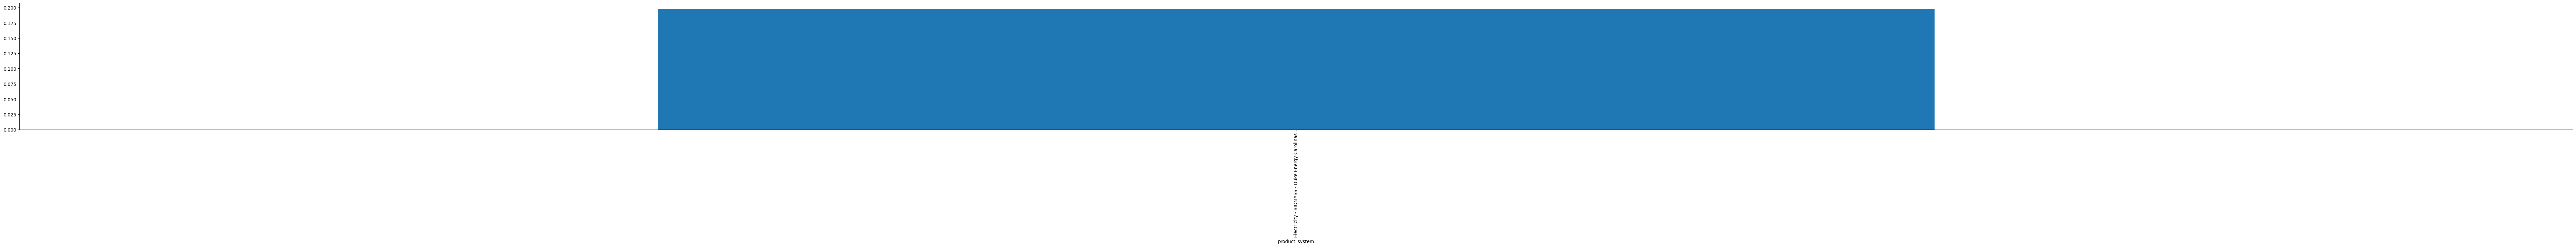

In [33]:
plt.rcParams['figure.figsize']=[100,5]
final_results_gwp.plot(kind='bar',x="product_system",y="amount",legend=False)

Documentation says we should do this. This will clear the results in openLCA.
Make sure you've got all you needed

Lastly, save the GWP impact data to its own CSV file.

In [90]:
gwp_file = "all_techs_gwp.csv"
gwp_path = os.path.join(output_folder, gwp_file)
if os.path.isfile(gwp_path):
    print("Warning! Overwriting '%s'" % gwp_path)
final_results_gwp.to_csv(gwp_path, encoding="utf-8")

### End Step

In [27]:
for res in results.values():
    res.dispose()